In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
recent= session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(f"The most recent date is {recent}.")

The most recent date is 2010-01-01.


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
dt1 = dt.datetime.strptime(recent, '%Y-%m-%d') - dt.timedelta(days=365)
#this gives you the starting point

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > dt1).\
    order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df=df.rename(columns={'prcp' : 'Precipitation'})
df.head()

# Sort the dataframe by date
# done with order_by in results query

,Precipitation
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


<function matplotlib.pyplot.show(close=None, block=None)>

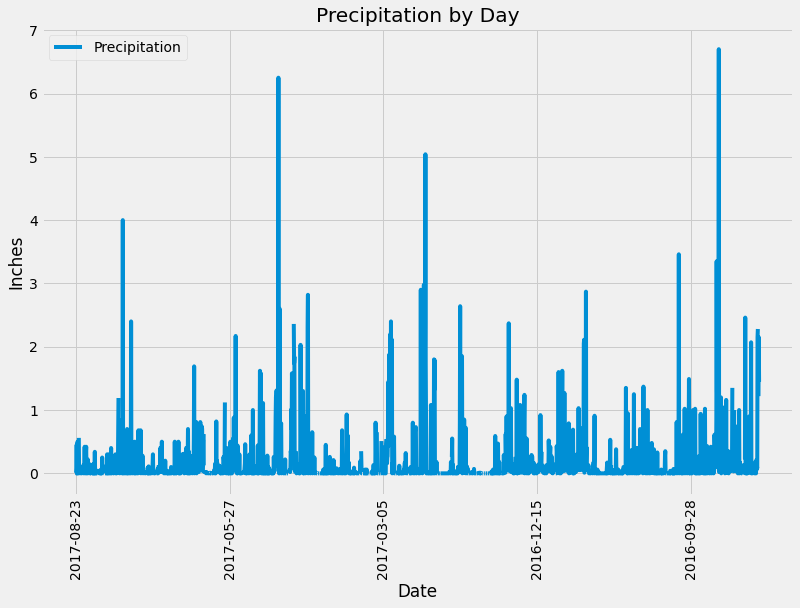

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot.line(rot=90,figsize=(12,8))
plt.tight_layout
plt.title('Precipitation by Day')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#Over the entire period
total_agg_results=df.agg({"Precipitation": [np.mean, np.median,np.var, np.std]})
total_agg_results

,Precipitation
mean,0.176462
median,0.020000
var,0.211865
std,0.460288


In [16]:
#Use Pandas to calcualte the summary statistics for the precipitation data
#By day over the entire period
daily_agg_results=df.groupby(["date"]).agg({"Precipitation": [np.mean, np.median,np.var, np.std]})
daily_agg_results.head()

Precipitation                           
                    mean median       var       std
date                                               
2016-08-24      1.555000  1.800  0.706510  0.840541
2016-08-25      0.077143  0.080  0.005157  0.071813
2016-08-26      0.016667  0.015  0.000267  0.016330
2016-08-27      0.064000  0.020  0.006680  0.081731
2016-08-28      0.516667  0.140  0.620427  0.787672

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_ct=session.query(Station.name).count()
print(f"There are {station_ct} stations.")

There are 9 stations.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station= session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
print(f"All stations (by ID) and counts are: {active_station}")
print(f"*" *20)
print(f"The most active station is {active_station[0]}.")
print(f"*" *20)

All stations (by ID) and counts are: [('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
********************
The most active station is ('USC00519281', 2772).
********************


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

busiest=active_station[0][0]
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == busiest).all()
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == busiest).all()
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == busiest).all()

print(f"The lowest temperature at station {busiest} was {lowest}." )
print(f"The highest temperature at station {busiest} was {highest}." )
print(f"The average temperature at station {busiest} was {avg}." )

The lowest temperature at station USC00519281 was [(54.0,)].
The highest temperature at station USC00519281 was [(85.0,)].
The average temperature at station USC00519281 was [(71.66378066378067,)].


In [ ]:
# Using the most active station id Query the last 12 months of temperature observation data for this station
results2 = session.query(Measurement.station,Measurement.tobs).\
    filter(Measurement.date > dt1).\
    filter(Measurement.station == busiest).all()
#results2

#put it in a DF for plotting

df2 = pd.DataFrame(results2, columns=['station', 'tobs'])
df2=df2.rename(columns={'tobs' : 'Temperature'})
df2.set_index('station', inplace=True, )
df2.head(10)

In [ ]:
#and plot the results as a histogram
df2.plot.hist(bins=12,figsize=(12,8))
plt.title("Temperature Observations for Station " + busiest)
plt.xlabel("Temperature Reported")
plt.show()

# Close session

In [25]:

calcs= session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max((Measurement.tobs)).filter(Measurement.date == recent).all()
print(calcs)

SyntaxError: invalid syntax (988526972.py, line 2)

In [ ]:
# Close Session
session.close()